In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")




# Feature Dimensionality Reduction Pipeline

This notebook implements a comprehensive PCA (Principal Component Analysis) pipeline for dimensionality reduction. The pipeline includes:

1. **Data preprocessing and standardization**
2. **Optimal component selection using multiple criteria**
3. **Visualization of explained variance**
4. **Performance evaluation with different component counts**
5. **Final transformation with optimal components**

The input dataframe should have the structure:
- `ID`: Unique identifier for each sample
- `Label`: Target variable for classification
- `Feature 1` to `Feature N`: High-dimensional feature columns

In [3]:
def pca_dimensionality_reduction(df, id_col='ID', label_col='Label', 
                                variance_threshold=0.95, max_components=None,
                                plot_results=True, cross_validate=True,
                                random_state=42):
    """
    Comprehensive PCA dimensionality reduction pipeline.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with ID, Label, and feature columns
    id_col : str
        Name of the ID column (default: 'ID')
    label_col : str
        Name of the label column (default: 'Label')
    variance_threshold : float
        Cumulative variance threshold for component selection (default: 0.95)
    max_components : int or None
        Maximum number of components to consider (default: None)
    plot_results : bool
        Whether to generate visualization plots (default: True)
    cross_validate : bool
        Whether to perform cross-validation for optimal component selection (default: True)
    random_state : int
        Random state for reproducibility (default: 42)
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'transformed_df': DataFrame with reduced dimensions
        - 'pca_model': Fitted PCA model
        - 'scaler': Fitted StandardScaler
        - 'optimal_components': Recommended number of components
        - 'explained_variance_ratio': Explained variance ratios
        - 'cumulative_variance': Cumulative explained variance
        - 'component_scores': Cross-validation scores for different component counts (if enabled)
    """
    
    print(f"Starting PCA dimensionality reduction pipeline...")
    print(f"Input shape: {df.shape}")
    
    # Separate features from ID and label columns
    feature_cols = [col for col in df.columns if col not in [id_col, label_col]]
    X = df[feature_cols].copy()
    y = df[label_col].copy()
    ids = df[id_col].copy()
    
    print(f"Number of features: {len(feature_cols)}")
    print(f"Number of samples: {len(X)}")
    print(f"Number of unique labels: {y.nunique()}")
    
    # Handle missing values
    if X.isnull().sum().sum() > 0:
        print(f"Warning: Found {X.isnull().sum().sum()} missing values. Filling with column means.")
        X = X.fillna(X.mean())
    
    # Standardize features
    print("\nStandardizing features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine maximum components to analyze
    if max_components is None:
        max_components = min(X_scaled.shape[0], X_scaled.shape[1], 100)  # Cap at 100 for efficiency
    else:
        max_components = min(max_components, X_scaled.shape[0], X_scaled.shape[1])
    
    print(f"Analyzing up to {max_components} components...")
    
    # Fit PCA with maximum components
    pca_full = PCA(n_components=max_components, random_state=random_state)
    X_pca_full = pca_full.fit_transform(X_scaled)
    
    # Calculate cumulative variance
    explained_variance_ratio = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Find optimal components based on variance threshold
    optimal_by_variance = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    print(f"\nVariance Analysis:")
    print(f"Components for {variance_threshold*100}% variance: {optimal_by_variance}")
    print(f"Variance explained by first 10 components: {cumulative_variance[9]:.3f}")
    print(f"Variance explained by first 20 components: {cumulative_variance[19]:.3f}")
    
    # Cross-validation for optimal component selection (if enabled)
    component_scores = None
    optimal_by_cv = optimal_by_variance
    
    if cross_validate and len(np.unique(y)) > 1:  # Only if we have multiple classes
        print("\nPerforming cross-validation to find optimal components...")
        
        # Test different component counts
        component_range = np.logspace(1, np.log10(min(50, max_components)), 10, dtype=int)
        component_range = np.unique(component_range)
        component_range = component_range[component_range <= max_components]
        
        cv_scores = []
        
        for n_comp in component_range:
            # Fit PCA with n_comp components
            pca_temp = PCA(n_components=n_comp, random_state=random_state)
            X_temp = pca_temp.fit_transform(X_scaled)
            
            # Cross-validate with logistic regression
            lr = LogisticRegression(random_state=random_state, max_iter=1000)
            scores = cross_val_score(lr, X_temp, y, cv=3, scoring='accuracy')
            cv_scores.append(scores.mean())
            
        component_scores = dict(zip(component_range, cv_scores))
        
        # Find optimal components by CV score
        best_cv_idx = np.argmax(cv_scores)
        optimal_by_cv = component_range[best_cv_idx]
        
        print(f"Optimal components by CV: {optimal_by_cv} (accuracy: {cv_scores[best_cv_idx]:.3f})")
    
    # Choose final optimal components (prefer CV if available, otherwise variance threshold)
    optimal_components = optimal_by_cv if cross_validate else optimal_by_variance
    
    print(f"\nSelected optimal components: {optimal_components}")
    
    # Fit final PCA model with optimal components
    pca_final = PCA(n_components=optimal_components, random_state=random_state)
    X_pca_final = pca_final.fit_transform(X_scaled)
    
    # Create transformed dataframe
    pca_columns = [f'PC{i+1}' for i in range(optimal_components)]
    transformed_df = pd.DataFrame(X_pca_final, columns=pca_columns)
    transformed_df[id_col] = ids.values
    transformed_df[label_col] = y.values
    
    # Reorder columns to have ID and Label first
    cols = [id_col, label_col] + pca_columns
    transformed_df = transformed_df[cols]
    
    print(f"Final transformed shape: {transformed_df.shape}")
    print(f"Dimensionality reduction: {len(feature_cols)} -> {optimal_components} ({100*optimal_components/len(feature_cols):.1f}% of original)")
    print(f"Variance retained: {cumulative_variance[optimal_components-1]:.3f}")
    
    # Generate visualizations
    if plot_results:
        _plot_pca_results(explained_variance_ratio, cumulative_variance, 
                         optimal_components, variance_threshold, component_scores)
    
    # Return results
    results = {
        'transformed_df': transformed_df,
        'pca_model': pca_final,
        'scaler': scaler,
        'optimal_components': optimal_components,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance,
        'component_scores': component_scores,
        'original_features': feature_cols,
        'variance_threshold': variance_threshold
    }
    
    return results

In [4]:
def _plot_pca_results(explained_variance_ratio, cumulative_variance, 
                     optimal_components, variance_threshold, component_scores=None):
    """
    Generate comprehensive plots for PCA analysis results.
    """
    
    # Create subplot layout
    if component_scores is not None:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()
    else:
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))
        if len(axes.shape) == 0:
            axes = [axes]
        else:
            axes = axes.ravel()
    
    # Plot 1: Individual explained variance
    axes[0].bar(range(1, min(21, len(explained_variance_ratio)+1)), 
               explained_variance_ratio[:20], alpha=0.7, color='skyblue')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_title('Individual Explained Variance by Component (First 20)')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Cumulative explained variance
    x_range = range(1, min(101, len(cumulative_variance)+1))
    axes[1].plot(x_range, cumulative_variance[:100], 'b-', linewidth=2, marker='o', markersize=3)
    axes[1].axhline(y=variance_threshold, color='r', linestyle='--', 
                   label=f'{variance_threshold*100}% threshold')
    axes[1].axvline(x=optimal_components, color='g', linestyle='--', 
                   label=f'Optimal: {optimal_components} components')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].set_title('Cumulative Explained Variance (First 100 Components)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Cross-validation scores (if available)
    if component_scores is not None:
        components = list(component_scores.keys())
        scores = list(component_scores.values())
        
        axes[2].plot(components, scores, 'ro-', linewidth=2, markersize=6)
        axes[2].set_xlabel('Number of Components')
        axes[2].set_ylabel('Cross-Validation Accuracy')
        axes[2].set_title('Cross-Validation Performance vs Number of Components')
        axes[2].grid(True, alpha=0.3)
        
        # Highlight optimal point
        best_idx = np.argmax(scores)
        axes[2].annotate(f'Optimal: {components[best_idx]}\nAccuracy: {scores[best_idx]:.3f}',
                        xy=(components[best_idx], scores[best_idx]),
                        xytext=(10, 10), textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
        
        # Plot 4: Elbow method visualization
        axes[3].plot(range(1, min(51, len(explained_variance_ratio)+1)), 
                    explained_variance_ratio[:50], 'go-', linewidth=2, markersize=4)
        axes[3].set_xlabel('Principal Component')
        axes[3].set_ylabel('Explained Variance Ratio')
        axes[3].set_title('Scree Plot - Elbow Method (First 50 Components)')
        axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("PCA ANALYSIS SUMMARY")
    print("="*60)
    print(f"Total components analyzed: {len(explained_variance_ratio)}")
    print(f"Optimal components selected: {optimal_components}")
    print(f"Variance explained by optimal components: {cumulative_variance[optimal_components-1]:.3f}")
    print(f"Top 5 component variances: {explained_variance_ratio[:5]}")
    print(f"Dimensionality reduction ratio: {optimal_components/len(explained_variance_ratio):.3f}")
    
    if component_scores is not None:
        best_score = max(component_scores.values())
        best_components = [k for k, v in component_scores.items() if v == best_score][0]
        print(f"Best CV performance: {best_score:.3f} with {best_components} components")

In [5]:
def apply_pca_transform(new_df, pca_results, id_col='ID', label_col='Label'):
    """
    Apply fitted PCA transformation to new data.
    
    Parameters:
    -----------
    new_df : pandas.DataFrame
        New dataframe to transform (must have same feature structure as training data)
    pca_results : dict
        Results dictionary from pca_dimensionality_reduction function
    id_col : str
        Name of the ID column
    label_col : str
        Name of the label column
    
    Returns:
    --------
    pandas.DataFrame
        Transformed dataframe with reduced dimensions
    """
    
    # Extract components from results
    pca_model = pca_results['pca_model']
    scaler = pca_results['scaler']
    original_features = pca_results['original_features']
    
    # Verify features match
    new_features = [col for col in new_df.columns if col not in [id_col, label_col]]
    
    if set(new_features) != set(original_features):
        missing_features = set(original_features) - set(new_features)
        extra_features = set(new_features) - set(original_features)
        
        error_msg = "Feature mismatch between training and new data:\n"
        if missing_features:
            error_msg += f"Missing features: {missing_features}\n"
        if extra_features:
            error_msg += f"Extra features: {extra_features}\n"
        
        raise ValueError(error_msg)
    
    # Extract and prepare features
    X_new = new_df[original_features].copy()
    ids = new_df[id_col].copy() if id_col in new_df.columns else None
    labels = new_df[label_col].copy() if label_col in new_df.columns else None
    
    # Handle missing values
    if X_new.isnull().sum().sum() > 0:
        print(f"Warning: Found {X_new.isnull().sum().sum()} missing values. Filling with column means.")
        X_new = X_new.fillna(X_new.mean())
    
    # Apply scaling and PCA transformation
    X_scaled = scaler.transform(X_new)
    X_transformed = pca_model.transform(X_scaled)
    
    # Create transformed dataframe
    n_components = pca_model.n_components_
    pca_columns = [f'PC{i+1}' for i in range(n_components)]
    
    transformed_df = pd.DataFrame(X_transformed, columns=pca_columns)
    
    # Add ID and label columns if they exist
    if ids is not None:
        transformed_df[id_col] = ids.values
    if labels is not None:
        transformed_df[label_col] = labels.values
    
    # Reorder columns
    cols = []
    if ids is not None:
        cols.append(id_col)
    if labels is not None:
        cols.append(label_col)
    cols.extend(pca_columns)
    
    transformed_df = transformed_df[cols]
    
    print(f"Applied PCA transformation: {X_new.shape} -> {transformed_df[pca_columns].shape}")
    
    return transformed_df

In [6]:
df = pd.read_csv('../../pipeline_output/data/metadata/isic_2019_preprocessed.csv')


In [7]:
df.groupby('label').size()

label
AK      1000
BCC     1000
BKL     1000
DF      1000
MEL     1000
NV      1000
SCC     1000
VASC    1000
dtype: int64

In [51]:
df

,original_image,processed_image,local_path,label,augmentation,width,height
0,ISIC_0068849,ISIC_0068849_preprocessed_rot0.jpg,../pipeline_output/images/processed/isic_2019/...,NV,rot0,450,450
1,ISIC_0068458,ISIC_0068458_preprocessed_rot0.jpg,../pipeline_output/images/processed/isic_2019/...,NV,rot0,450,450
2,ISIC_0000011,ISIC_0000011_preprocessed_rot0.jpg,../pipeline_output/images/processed/isic_2019/...,NV,rot0,450,450
3,ISIC_0010585,ISIC_0010585_preprocessed_rot0.jpg,../pipeline_output/images/processed/isic_2019/...,NV,rot0,450,450
4,ISIC_0025080,ISIC_0025080_preprocessed_rot0.jpg,../pipeline_output/images/processed/isic_2019/...,NV,rot0,450,450
...,...,...,...,...,...,...,...
7995,ISIC_0073112,ISIC_0073112_preprocessed_rot0.jpg,../pipeline_output/images/processed/isic_2019/...,DF,rot0,450,450
7996,ISIC_0073112,ISIC_0073112_preprocessed_rot90.jpg,../pipeline_output/images/processed/isic_2019/...,DF,rot90,450,450
7997,ISIC_0073112,ISIC_0073112_preprocessed_rot180.jpg,../pipeline_output/images/processed/isic_2019/...,DF,rot180,450,450
7998,ISIC_0073112,ISIC_0073112_preprocessed_rot270.jpg,../pipeline_output/images/processed/isic_2019/...,DF,rot270,450,450


In [ ]:
## Example Usage

# Here's how to use the PCA dimensionality reduction pipeline with your data:

Found 10 feature files: ['contrast_features', 'color_features', 'hog_features', 'hsv_color_features', 'glcm_features', 'circularity_features', 'laplace_features', 'wavelet_features', 'lbp_features', 'efficientnet_features']

Processing contrast_features features...
Loaded contrast_features shape: (8000, 4)
Created feature DataFrame shape: (8000, 6)
Label distribution:
Label
NV      1000
MEL     1000
BCC     1000
BKL     1000
AK      1000
SCC     1000
VASC    1000
DF      1000
Name: count, dtype: int64

Running PCA analysis for contrast_features...
Starting PCA dimensionality reduction pipeline...
Input shape: (8000, 6)
Number of features: 4
Number of samples: 8000
Number of unique labels: 8

Standardizing features...
Analyzing up to 4 components...

Variance Analysis:
Components for 95.0% variance: 3
Error processing contrast_features: index 9 is out of bounds for axis 0 with size 4

Processing color_features features...
Loaded color_features shape: (8000, 96)
Created feature DataFrame

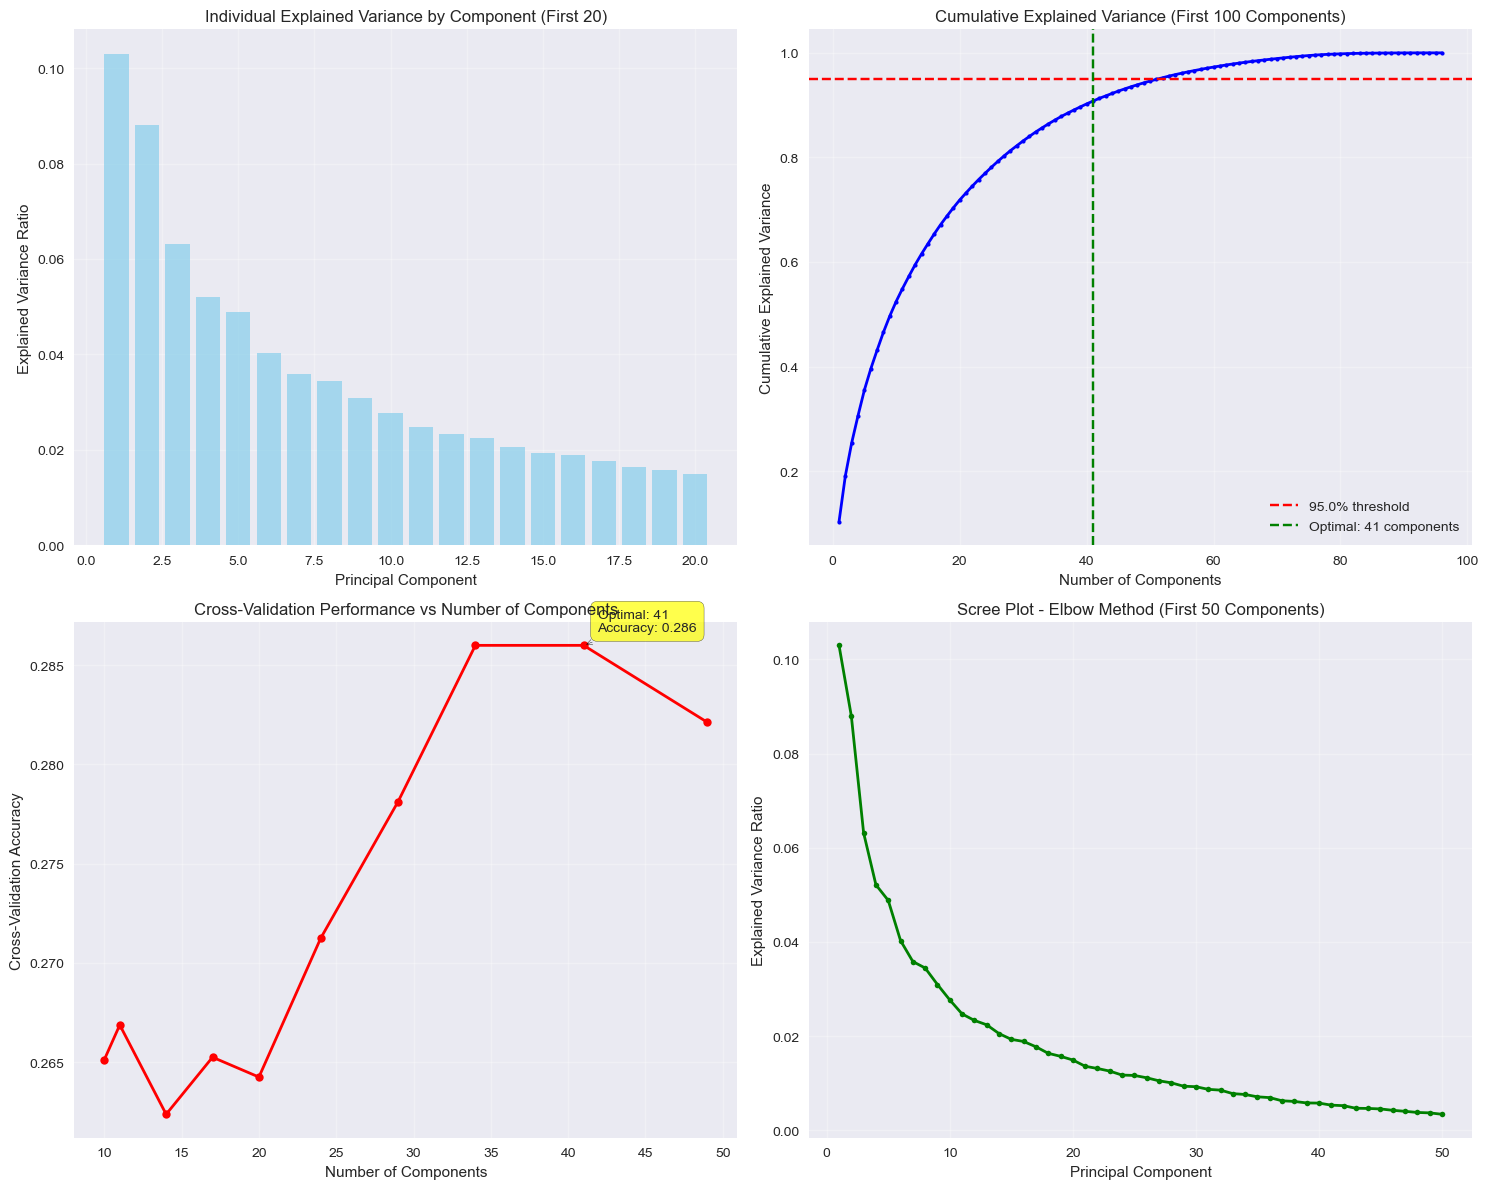


PCA ANALYSIS SUMMARY
Total components analyzed: 96
Optimal components selected: 41
Variance explained by optimal components: 0.908
Top 5 component variances: [0.10297061 0.08798947 0.06315343 0.05212952 0.04882398]
Dimensionality reduction ratio: 0.427
Best CV performance: 0.286 with 41 components
Saved PCA-reduced features to: ../pipeline_output/features/pca_reduced/color_features_pca_reduced.csv
Saved PCA model to: ../pipeline_output/features/pca_reduced/color_features_pca_model.pkl
Saved scaler to: ../pipeline_output/features/pca_reduced/color_features_scaler.pkl

color_features PCA Summary:
  Original dimensions: 96
  Optimal components: 41
  Variance explained: 0.908
  Reduction ratio: 0.427

Processing hog_features features...
Loaded hog_features shape: (8000, 11664)
Created feature DataFrame shape: (8000, 11666)
Label distribution:
Label
NV      1000
MEL     1000
BCC     1000
BKL     1000
AK      1000
SCC     1000
VASC    1000
DF      1000
Name: count, dtype: int64

Running PCA

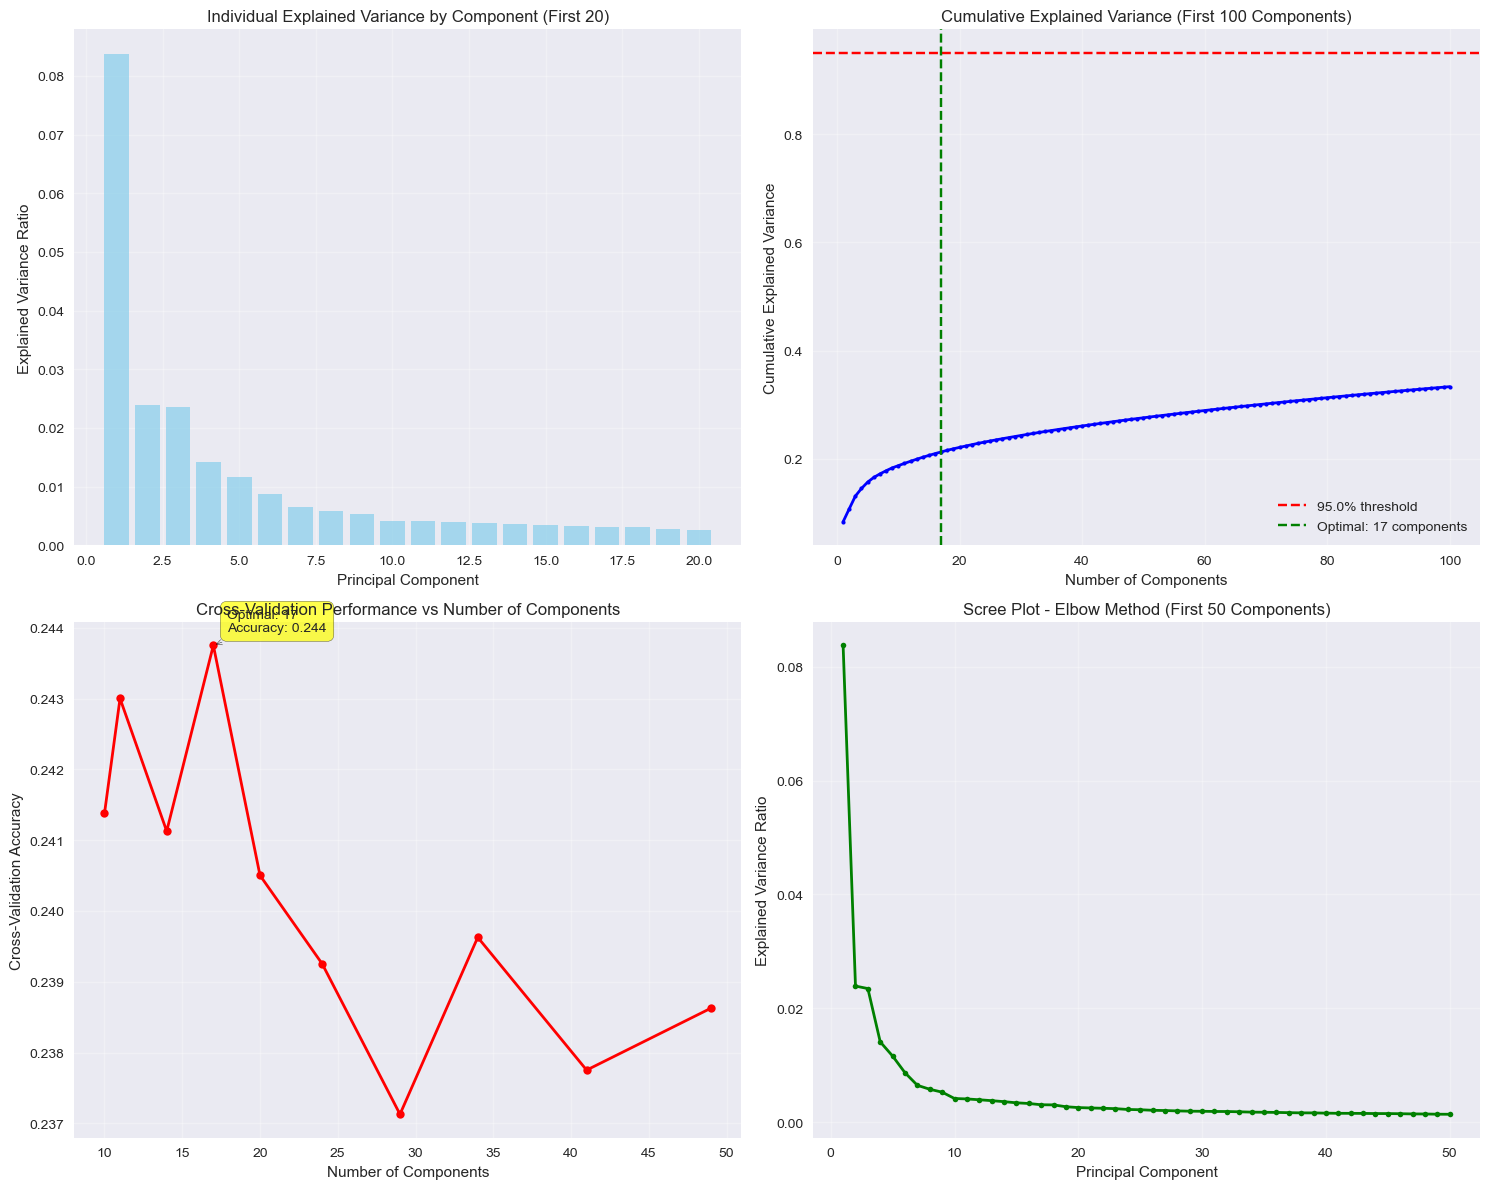


PCA ANALYSIS SUMMARY
Total components analyzed: 100
Optimal components selected: 17
Variance explained by optimal components: 0.213
Top 5 component variances: [0.08373666 0.02392441 0.02348653 0.01412287 0.01163744]
Dimensionality reduction ratio: 0.170
Best CV performance: 0.244 with 17 components
Saved PCA-reduced features to: ../pipeline_output/features/pca_reduced/hog_features_pca_reduced.csv
Saved PCA model to: ../pipeline_output/features/pca_reduced/hog_features_pca_model.pkl
Saved scaler to: ../pipeline_output/features/pca_reduced/hog_features_scaler.pkl

hog_features PCA Summary:
  Original dimensions: 11664
  Optimal components: 17
  Variance explained: 0.213
  Reduction ratio: 0.001

Processing hsv_color_features features...
Loaded hsv_color_features shape: (8000, 9)
Created feature DataFrame shape: (8000, 11)
Label distribution:
Label
NV      1000
MEL     1000
BCC     1000
BKL     1000
AK      1000
SCC     1000
VASC    1000
DF      1000
Name: count, dtype: int64

Running PC

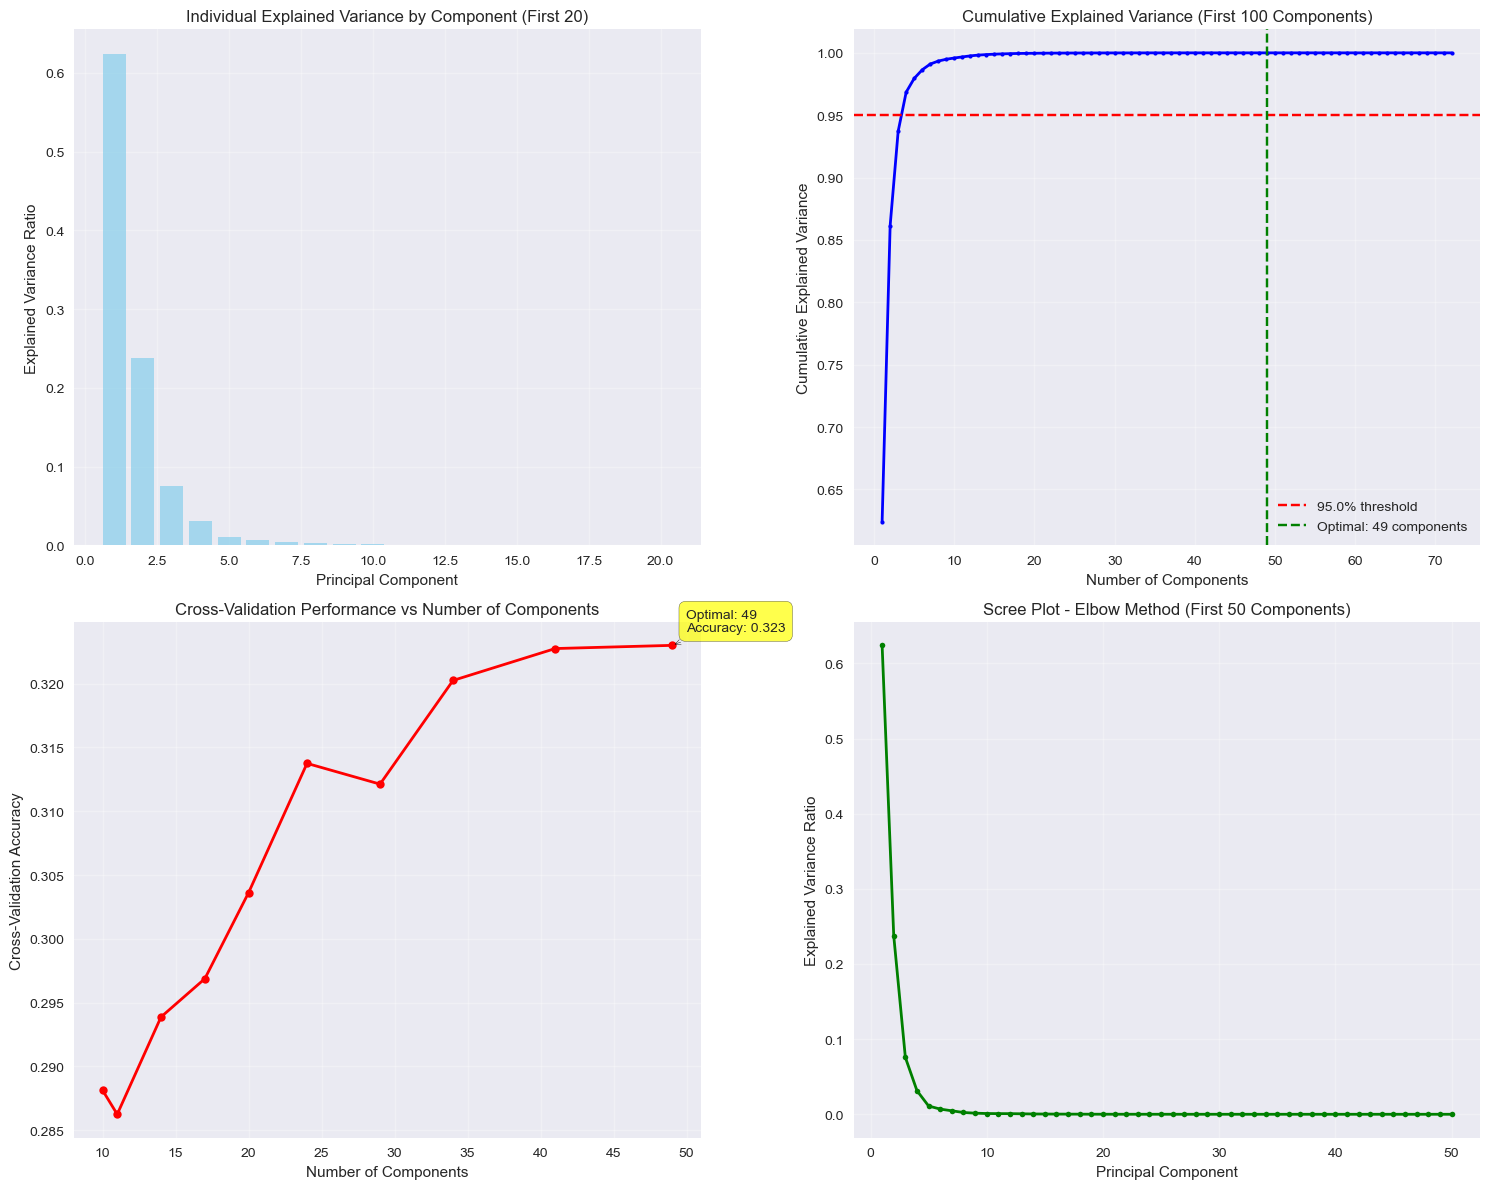


PCA ANALYSIS SUMMARY
Total components analyzed: 72
Optimal components selected: 49
Variance explained by optimal components: 1.000
Top 5 component variances: [0.62404165 0.23742092 0.07565908 0.03137228 0.01101221]
Dimensionality reduction ratio: 0.681
Best CV performance: 0.323 with 49 components
Saved PCA-reduced features to: ../pipeline_output/features/pca_reduced/glcm_features_pca_reduced.csv
Saved PCA model to: ../pipeline_output/features/pca_reduced/glcm_features_pca_model.pkl
Saved scaler to: ../pipeline_output/features/pca_reduced/glcm_features_scaler.pkl

glcm_features PCA Summary:
  Original dimensions: 72
  Optimal components: 49
  Variance explained: 1.000
  Reduction ratio: 0.681

Processing circularity_features features...
Loaded circularity_features shape: (8000, 3)
Created feature DataFrame shape: (8000, 5)
Label distribution:
Label
NV      1000
MEL     1000
BCC     1000
BKL     1000
AK      1000
SCC     1000
VASC    1000
DF      1000
Name: count, dtype: int64

Running

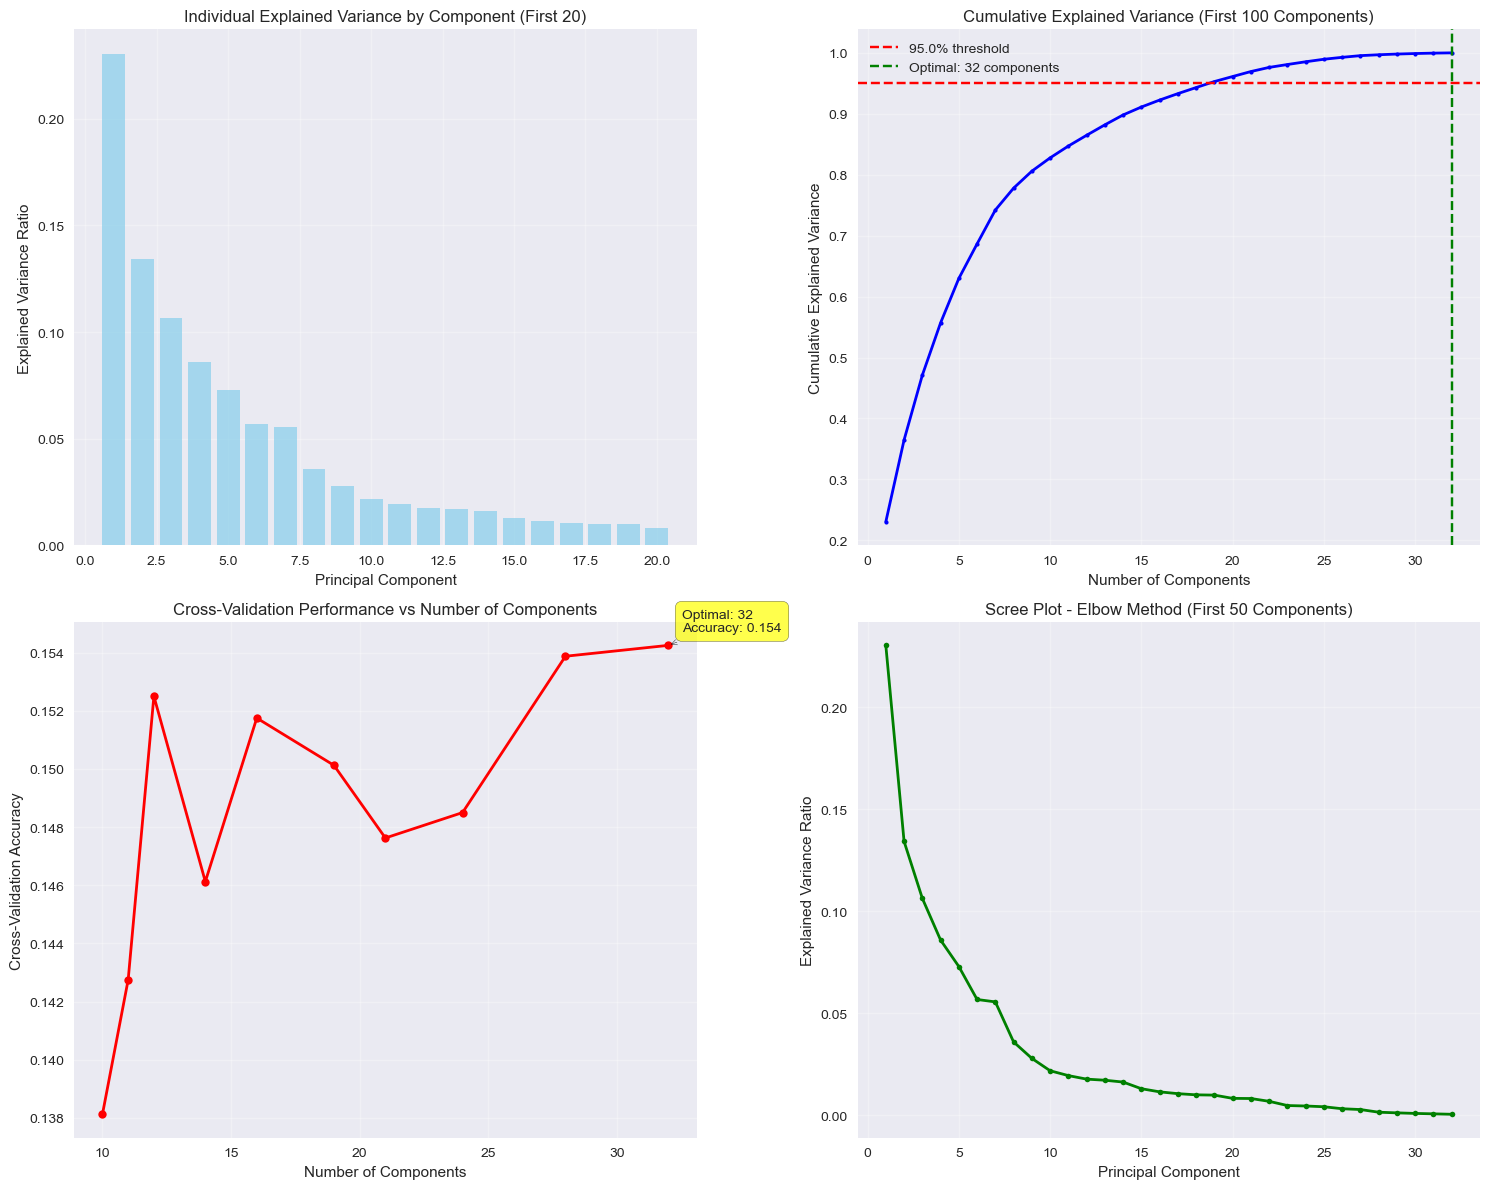


PCA ANALYSIS SUMMARY
Total components analyzed: 32
Optimal components selected: 32
Variance explained by optimal components: 1.000
Top 5 component variances: [0.23039828 0.13426249 0.10634288 0.08588466 0.0729056 ]
Dimensionality reduction ratio: 1.000
Best CV performance: 0.154 with 32 components
Saved PCA-reduced features to: ../pipeline_output/features/pca_reduced/laplace_features_pca_reduced.csv
Saved PCA model to: ../pipeline_output/features/pca_reduced/laplace_features_pca_model.pkl
Saved scaler to: ../pipeline_output/features/pca_reduced/laplace_features_scaler.pkl

laplace_features PCA Summary:
  Original dimensions: 32
  Optimal components: 32
  Variance explained: 1.000
  Reduction ratio: 1.000

Processing wavelet_features features...
Loaded wavelet_features shape: (8000, 1000)
Created feature DataFrame shape: (8000, 1002)
Label distribution:
Label
NV      1000
MEL     1000
BCC     1000
BKL     1000
AK      1000
SCC     1000
VASC    1000
DF      1000
Name: count, dtype: int6

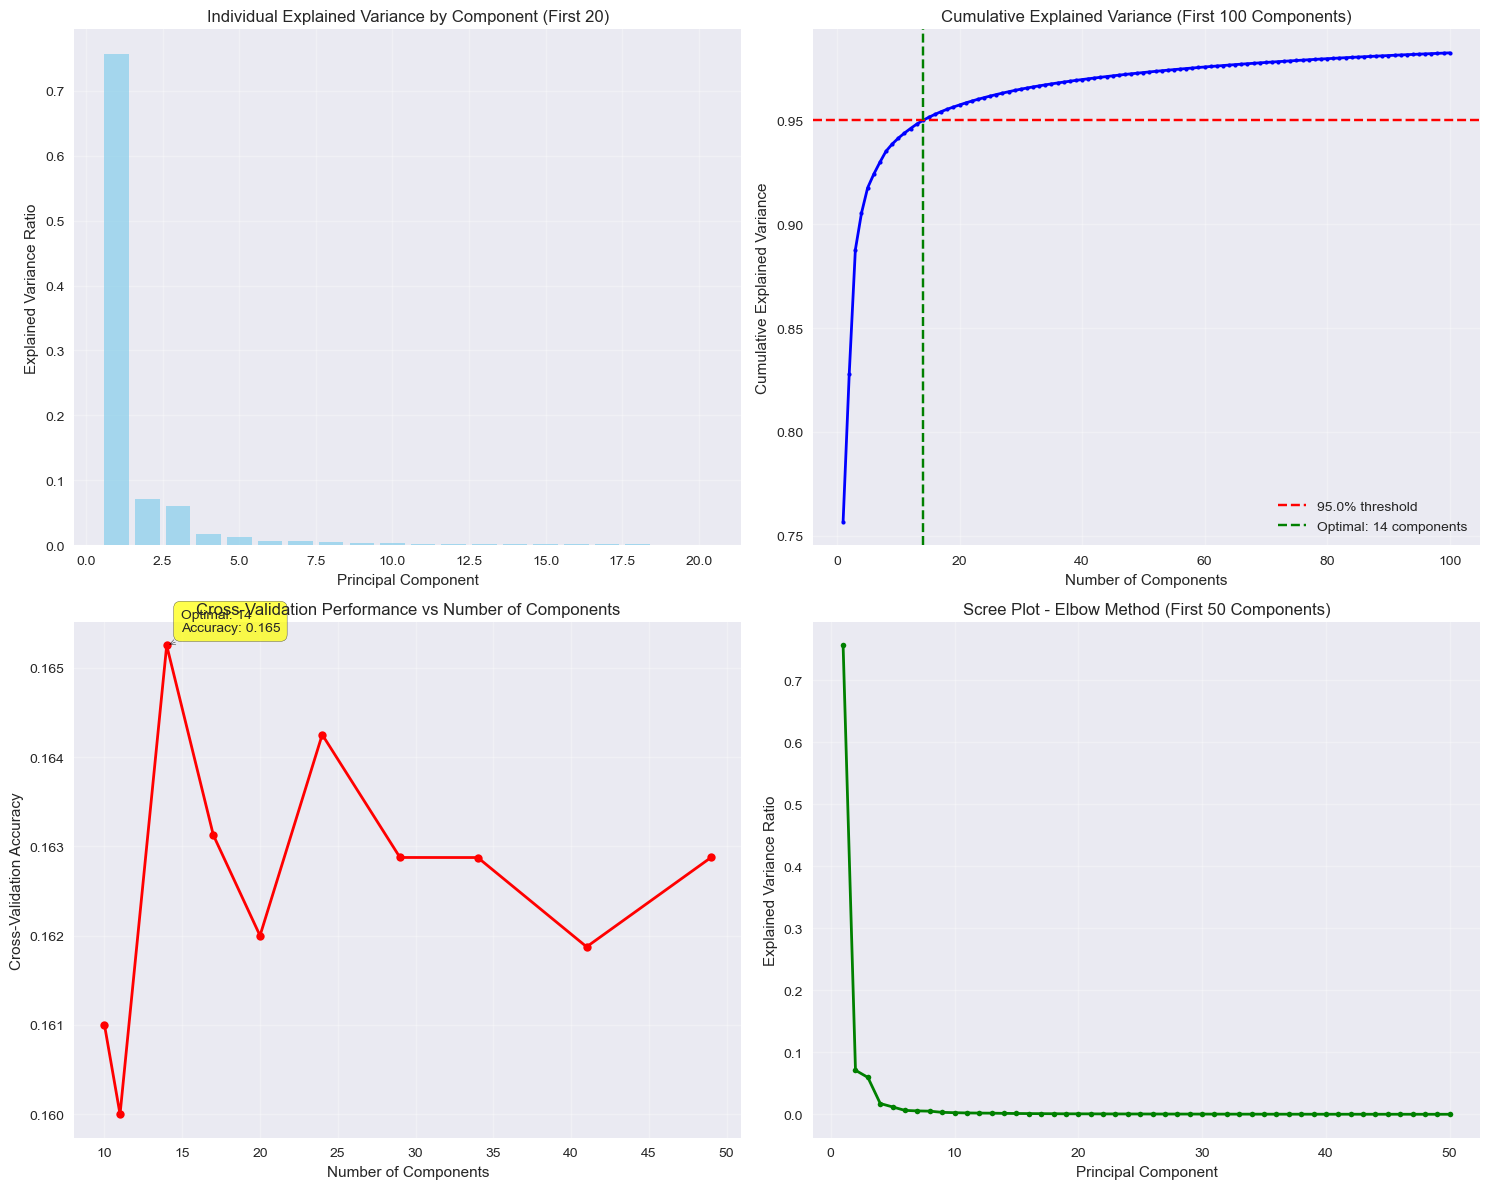


PCA ANALYSIS SUMMARY
Total components analyzed: 100
Optimal components selected: 14
Variance explained by optimal components: 0.950
Top 5 component variances: [0.75664455 0.07126777 0.05978326 0.01765833 0.01215201]
Dimensionality reduction ratio: 0.140
Best CV performance: 0.165 with 14 components
Saved PCA-reduced features to: ../pipeline_output/features/pca_reduced/wavelet_features_pca_reduced.csv
Saved PCA model to: ../pipeline_output/features/pca_reduced/wavelet_features_pca_model.pkl
Saved scaler to: ../pipeline_output/features/pca_reduced/wavelet_features_scaler.pkl

wavelet_features PCA Summary:
  Original dimensions: 1000
  Optimal components: 14
  Variance explained: 0.950
  Reduction ratio: 0.014

Processing lbp_features features...
Loaded lbp_features shape: (8000, 26)
Created feature DataFrame shape: (8000, 28)
Label distribution:
Label
NV      1000
MEL     1000
BCC     1000
BKL     1000
AK      1000
SCC     1000
VASC    1000
DF      1000
Name: count, dtype: int64

Runnin

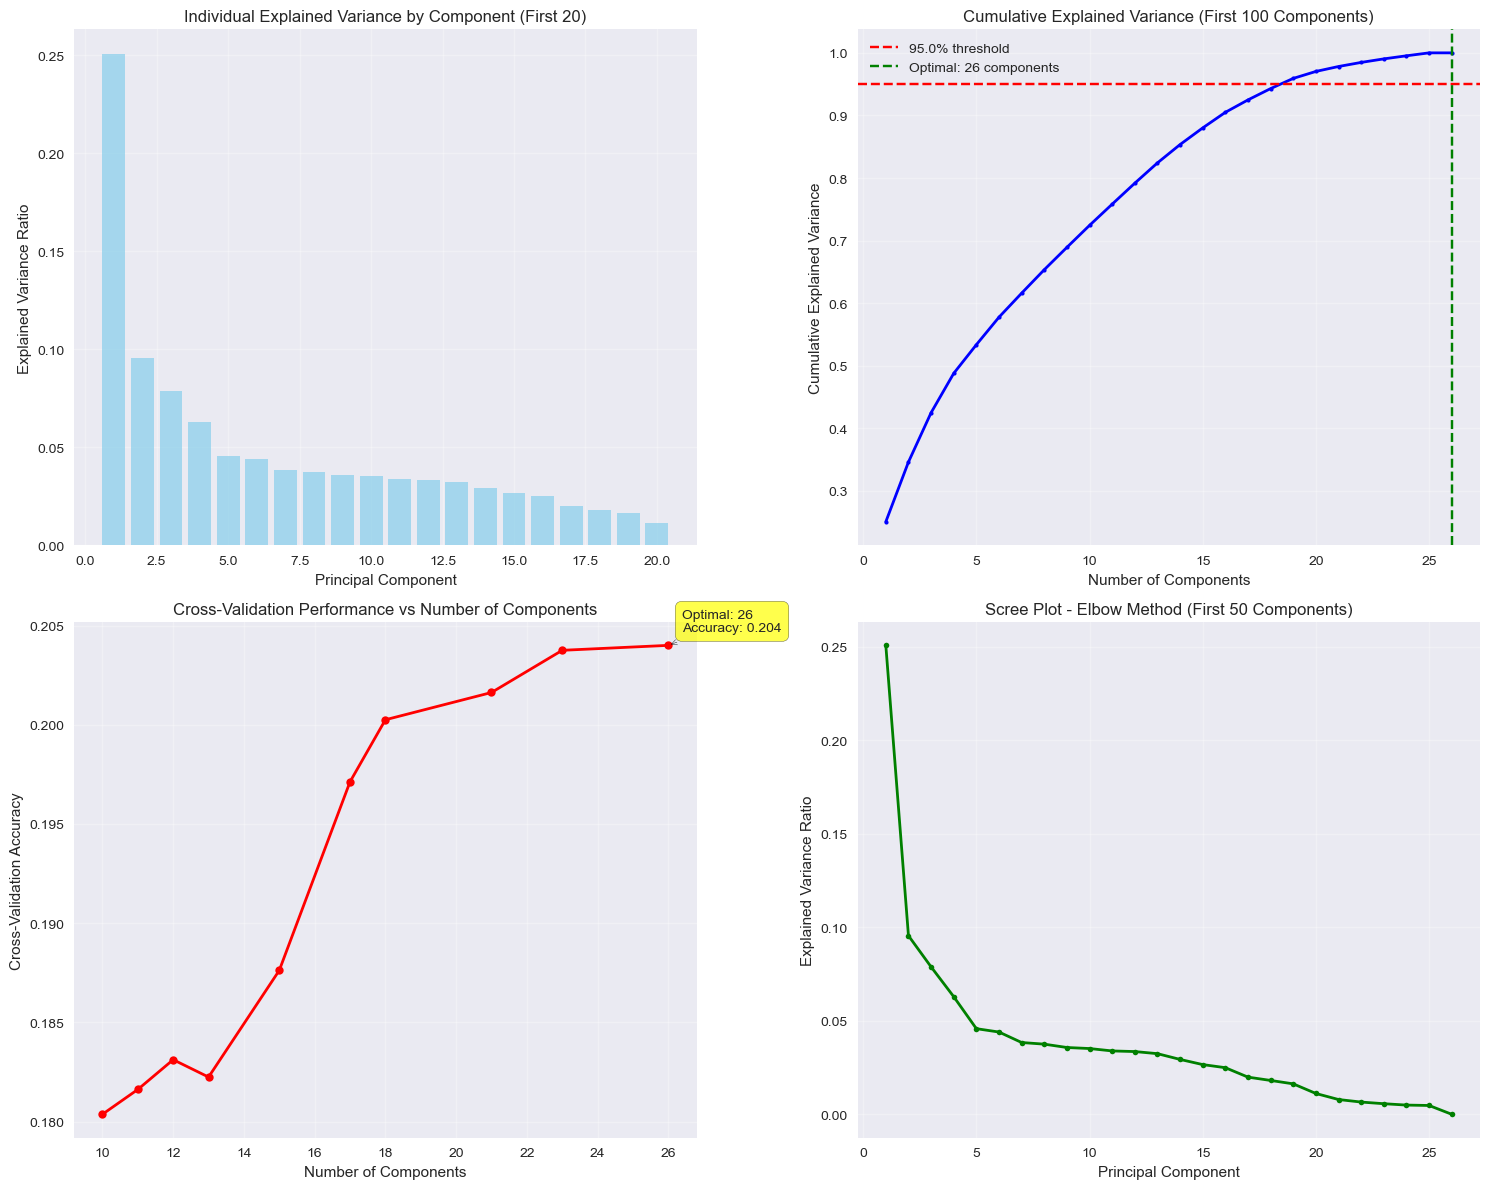


PCA ANALYSIS SUMMARY
Total components analyzed: 26
Optimal components selected: 26
Variance explained by optimal components: 1.000
Top 5 component variances: [0.25072298 0.09548329 0.07881117 0.0628761  0.04577513]
Dimensionality reduction ratio: 1.000
Best CV performance: 0.204 with 26 components
Saved PCA-reduced features to: ../pipeline_output/features/pca_reduced/lbp_features_pca_reduced.csv
Saved PCA model to: ../pipeline_output/features/pca_reduced/lbp_features_pca_model.pkl
Saved scaler to: ../pipeline_output/features/pca_reduced/lbp_features_scaler.pkl

lbp_features PCA Summary:
  Original dimensions: 26
  Optimal components: 26
  Variance explained: 1.000
  Reduction ratio: 1.000

Processing efficientnet_features features...
Loaded efficientnet_features shape: (8000, 153600)
Created feature DataFrame shape: (8000, 153602)
Label distribution:
Label
NV      1000
MEL     1000
BCC     1000
BKL     1000
AK      1000
SCC     1000
VASC    1000
DF      1000
Name: count, dtype: int64


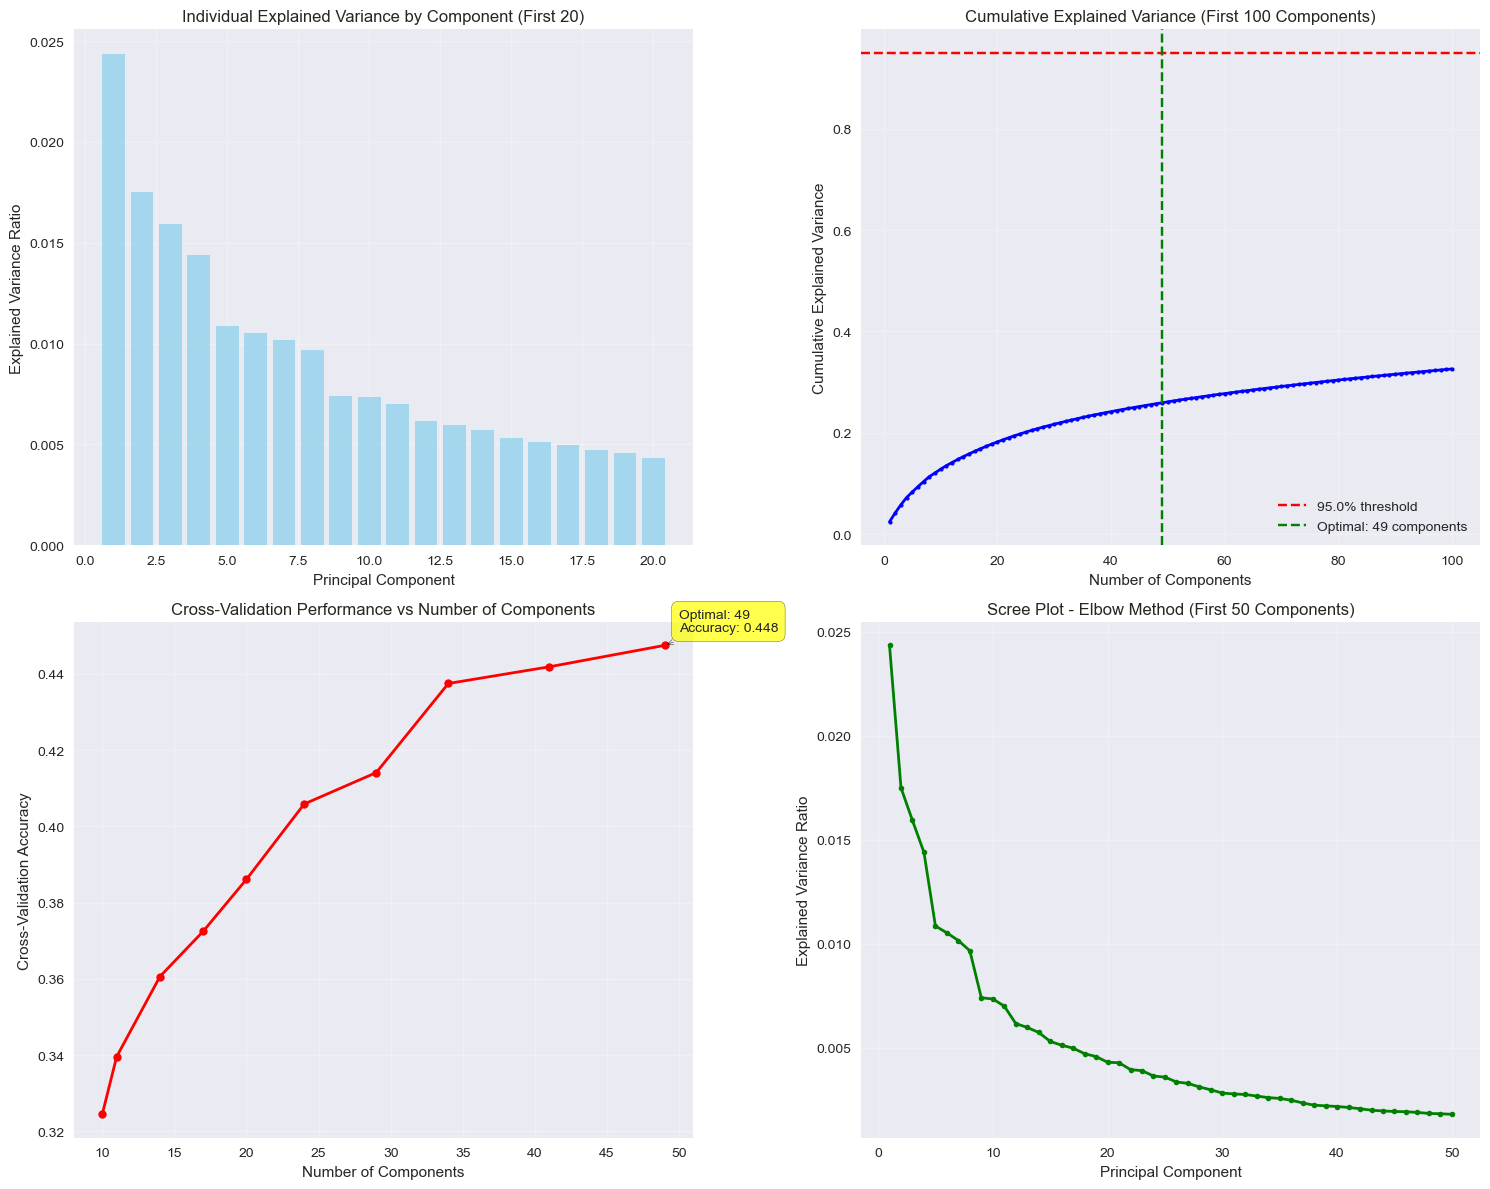


PCA ANALYSIS SUMMARY
Total components analyzed: 100
Optimal components selected: 49
Variance explained by optimal components: 0.259
Top 5 component variances: [0.02435683 0.01750459 0.01593227 0.01440198 0.01085482]
Dimensionality reduction ratio: 0.490
Best CV performance: 0.448 with 49 components
Saved PCA-reduced features to: ../pipeline_output/features/pca_reduced/efficientnet_features_pca_reduced.csv
Saved PCA model to: ../pipeline_output/features/pca_reduced/efficientnet_features_pca_model.pkl
Saved scaler to: ../pipeline_output/features/pca_reduced/efficientnet_features_scaler.pkl

efficientnet_features PCA Summary:
  Original dimensions: 153600
  Optimal components: 49
  Variance explained: 0.259
  Reduction ratio: 0.000


In [10]:
import os
import joblib
from pathlib import Path

def process_feature_files_with_pca(metadata_df, features_dir='../pipeline_output/features/final/isic_2019', 
                                   output_dir='../pipeline_output/features/pca_reduced',
                                   variance_threshold=0.95, max_components=100):
    """
    Process all .npy feature files with PCA analysis and save reduced features.
    
    Parameters:
    -----------
    metadata_df : pandas.DataFrame
        Metadata dataframe with image information
    features_dir : str
        Directory containing .npy feature files
    output_dir : str
        Directory to save PCA-reduced features and models
    variance_threshold : float
        Variance threshold for PCA component selection
    max_components : int
        Maximum components to analyze for efficiency
    
    Returns:
    --------
    dict : Results for each feature type
    """
    
    # Create output directory
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Find all .npy files
    feature_files = list(Path(features_dir).glob('*.npy'))
    print(f"Found {len(feature_files)} feature files: {[f.stem for f in feature_files]}")
    
    results = {}
    
    for feature_file in feature_files:
        feature_name = feature_file.stem
        print(f"\n{'='*60}")
        print(f"Processing {feature_name} features...")
        print(f"{'='*60}")
        
        try:
            # Load feature data
            feature_data = np.load(feature_file)
            print(f"Loaded {feature_name} shape: {feature_data.shape}")
            
            # Create feature DataFrame
            n_samples, n_features = feature_data.shape
            
            # Create feature column names
            feature_cols = [f'{feature_name}_feature_{i+1}' for i in range(n_features)]
            
            # Create DataFrame with features
            feature_df = pd.DataFrame(feature_data, columns=feature_cols)
            
            # Add metadata columns
            feature_df['ID'] = metadata_df['processed_image'].values[:n_samples]
            feature_df['Label'] = metadata_df['label'].values[:n_samples]
            
            # Reorder columns to have ID and Label first
            cols = ['ID', 'Label'] + feature_cols
            feature_df = feature_df[cols]
            
            print(f"Created feature DataFrame shape: {feature_df.shape}")
            print(f"Label distribution:\n{feature_df['Label'].value_counts()}")
            
            # Run PCA analysis
            print(f"\nRunning PCA analysis for {feature_name}...")
            pca_results = pca_dimensionality_reduction(
                df=feature_df,
                id_col='ID',
                label_col='Label',
                variance_threshold=variance_threshold,
                max_components=max_components,
                plot_results=True,
                cross_validate=True,
                random_state=42
            )
            
            # Save PCA-reduced features
            reduced_features_path = Path(output_dir) / f'{feature_name}_pca_reduced.csv'
            pca_results['transformed_df'].to_csv(reduced_features_path, index=False)
            print(f"Saved PCA-reduced features to: {reduced_features_path}")
            
            # Save PCA model and scaler for future use
            model_path = Path(output_dir) / f'{feature_name}_pca_model.pkl'
            scaler_path = Path(output_dir) / f'{feature_name}_scaler.pkl'
            
            joblib.dump(pca_results['pca_model'], model_path)
            joblib.dump(pca_results['scaler'], scaler_path)
            print(f"Saved PCA model to: {model_path}")
            print(f"Saved scaler to: {scaler_path}")
            
            # Store results
            results[feature_name] = {
                'pca_results': pca_results,
                'original_shape': feature_data.shape,
                'reduced_shape': pca_results['transformed_df'].shape,
                'optimal_components': pca_results['optimal_components'],
                'variance_explained': pca_results['cumulative_variance'][pca_results['optimal_components']-1],
                'reduction_ratio': pca_results['optimal_components'] / n_features,
                'file_paths': {
                    'reduced_features': reduced_features_path,
                    'pca_model': model_path,
                    'scaler': scaler_path
                }
            }
            
            print(f"\n{feature_name} PCA Summary:")
            print(f"  Original dimensions: {n_features}")
            print(f"  Optimal components: {pca_results['optimal_components']}")
            print(f"  Variance explained: {pca_results['cumulative_variance'][pca_results['optimal_components']-1]:.3f}")
            print(f"  Reduction ratio: {pca_results['optimal_components'] / n_features:.3f}")
            
        except Exception as e:
            print(f"Error processing {feature_name}: {str(e)}")
            results[feature_name] = {'error': str(e)}
    
    return results

# Process all feature files
pca_analysis_results = process_feature_files_with_pca(
    metadata_df=df,
    features_dir='../pipeline_output/features/final/isic_2019',
    output_dir='../pipeline_output/features/pca_reduced',
    variance_threshold=0.95,
    max_components=100
)



In [11]:
def combine_pca_features(pca_analysis_results, metadata_df, output_path=None):
    """
    Combine all successfully processed PCA-reduced features into a single dataframe.
    
    Parameters:
    -----------
    pca_analysis_results : dict
        Results from process_feature_files_with_pca function
    metadata_df : pandas.DataFrame
        Original metadata dataframe for ID mapping
    output_path : str, optional
        Path to save the combined features CSV file
    
    Returns:
    --------
    pandas.DataFrame
        Combined dataframe with all PCA-reduced features
    """
    
    print("Combining PCA-reduced features...")
    
    # Start with metadata as base
    combined_df = metadata_df[['processed_image', 'label']].copy()
    combined_df = combined_df.rename(columns={'processed_image': 'ID', 'label': 'Label'})
    
    successful_features = []
    failed_features = []
    
    # Process each feature type
    for feature_name, result in pca_analysis_results.items():
        if 'error' in result:
            failed_features.append(feature_name)
            print(f"Skipping {feature_name}: {result['error']}")
            continue
            
        try:
            # Load the PCA-reduced features
            pca_df = result['pca_results']['transformed_df']
            
            # Get only the PCA component columns (exclude ID and Label)
            pca_columns = [col for col in pca_df.columns if col.startswith('PC')]
            
            # Rename columns to include feature type prefix
            renamed_columns = {col: f"{feature_name}_{col}" for col in pca_columns}
            pca_features = pca_df[pca_columns].rename(columns=renamed_columns)
            
            # Add ID for merging
            pca_features['ID'] = pca_df['ID']
            
            # Merge with combined dataframe
            combined_df = combined_df.merge(pca_features, on='ID', how='left')
            
            successful_features.append(feature_name)
            print(f"Added {feature_name}: {len(pca_columns)} components")
            
        except Exception as e:
            failed_features.append(feature_name)
            print(f"Error processing {feature_name}: {str(e)}")
    
    # Summary
    total_features = len([col for col in combined_df.columns if col not in ['ID', 'Label']])
    
    print(f"\nCombination Summary:")
    print(f"Successfully combined features: {len(successful_features)}")
    print(f"Failed features: {len(failed_features)}")
    print(f"Total PCA components: {total_features}")
    print(f"Final dataframe shape: {combined_df.shape}")
    
    print(f"\nSuccessful features: {successful_features}")
    if failed_features:
        print(f"Failed features: {failed_features}")
    
    # Feature breakdown by type
    print(f"\nFeature breakdown:")
    for feature_name in successful_features:
        feature_cols = [col for col in combined_df.columns if col.startswith(f"{feature_name}_PC")]
        print(f"  {feature_name}: {len(feature_cols)} components")
    
    # Save if path provided
    if output_path:
        combined_df.to_csv(output_path, index=False)
        print(f"\nSaved combined features to: {output_path}")
    
    return combined_df

# Combine all PCA-reduced features
combined_features_df = combine_pca_features(
    pca_analysis_results=pca_analysis_results,
    metadata_df=df,
    output_path='../pipeline_output/features/pca_reduced/combined_pca_features.csv'
)

# Display the combined dataframe info
print(f"\nCombined features dataframe:")
print(f"Shape: {combined_features_df.shape}")
print(f"\nFirst few rows:")
print(combined_features_df.head())

print(f"\nLabel distribution:")
print(combined_features_df['Label'].value_counts())

print(f"\nColumn types:")
feature_columns = [col for col in combined_features_df.columns if col not in ['ID', 'Label']]
print(f"ID column: 1")
print(f"Label column: 1") 
print(f"Feature columns: {len(feature_columns)}")
print(f"All feature columns are numeric: {combined_features_df[feature_columns].dtypes.apply(lambda x: x.kind in 'biufc').all()}")

Combining PCA-reduced features...
Skipping contrast_features: index 9 is out of bounds for axis 0 with size 4
Added color_features: 41 components
Added hog_features: 17 components
Skipping hsv_color_features: index 9 is out of bounds for axis 0 with size 9
Added glcm_features: 49 components
Skipping circularity_features: index 9 is out of bounds for axis 0 with size 3
Added laplace_features: 32 components
Added wavelet_features: 14 components
Added lbp_features: 26 components
Added efficientnet_features: 49 components

Combination Summary:
Successfully combined features: 7
Failed features: 3
Total PCA components: 228
Final dataframe shape: (8000, 230)

Successful features: ['color_features', 'hog_features', 'glcm_features', 'laplace_features', 'wavelet_features', 'lbp_features', 'efficientnet_features']
Failed features: ['contrast_features', 'hsv_color_features', 'circularity_features']

Feature breakdown:
  color_features: 41 components
  hog_features: 17 components
  glcm_features: 4

In [16]:
import numpy as np
import pandas as pd
from pathlib import Path

# Load the combined PCA features
combined_pca_df = pd.read_csv('../pipeline_output/features/pca_reduced/combined_pca_features.csv')

# List all .npy feature files
features_dir = '../pipeline_output/features/final/isic_2019'
feature_files = list(Path(features_dir).glob('*.npy'))

# Identify non-PCA features (those with errors in pca_analysis_results)
non_pca_features = [f.stem for f in feature_files if f.stem not in pca_analysis_results or 'error' in pca_analysis_results[f.stem]]

# Load metadata for ID and Label mapping
metadata_df = pd.read_csv('../pipeline_output/data/metadata/isic_2019_preprocessed.csv')

# Prepare a DataFrame to hold non-PCA features
non_pca_dfs = []

for feature_name in non_pca_features:
    feature_file = Path(features_dir) / f"{feature_name}.npy"
    feature_data = np.load(feature_file)
    n_samples, n_features = feature_data.shape
    feature_cols = [f"{feature_name}_feature_{i+1}" for i in range(n_features)]
    feature_df = pd.DataFrame(feature_data, columns=feature_cols)
    feature_df['ID'] = metadata_df['processed_image'].values[:n_samples]
    feature_df['Label'] = metadata_df['label'].values[:n_samples]
    # Only keep ID and feature columns for merging
    cols = ['ID'] + feature_cols
    feature_df = feature_df[cols]
    non_pca_dfs.append(feature_df)

# Merge all non-PCA features into one DataFrame
if non_pca_dfs:
    non_pca_features_df = non_pca_dfs[0]
    for df in non_pca_dfs[1:]:
        non_pca_features_df = non_pca_features_df.merge(df, on='ID', how='left')
else:
    non_pca_features_df = pd.DataFrame()

# Merge with combined PCA features
final_combined_df = combined_pca_df.merge(non_pca_features_df, on='ID', how='left')

# Save the final combined features
final_combined_df.to_csv('../pipeline_output/features/pca_reduced/combined_features.csv', index=False)
print("Saved combined features to ../pipeline_output/features/pca_reduced/combined_features.csv")

Saved combined features to ../pipeline_output/features/pca_reduced/combined_features.csv


In [17]:
df = pd.read_csv('../pipeline_output/features/pca_reduced/combined_features.csv')

In [22]:
df.columns.tolist()

['ID',
 'Label',
 'color_features_PC1',
 'color_features_PC2',
 'color_features_PC3',
 'color_features_PC4',
 'color_features_PC5',
 'color_features_PC6',
 'color_features_PC7',
 'color_features_PC8',
 'color_features_PC9',
 'color_features_PC10',
 'color_features_PC11',
 'color_features_PC12',
 'color_features_PC13',
 'color_features_PC14',
 'color_features_PC15',
 'color_features_PC16',
 'color_features_PC17',
 'color_features_PC18',
 'color_features_PC19',
 'color_features_PC20',
 'color_features_PC21',
 'color_features_PC22',
 'color_features_PC23',
 'color_features_PC24',
 'color_features_PC25',
 'color_features_PC26',
 'color_features_PC27',
 'color_features_PC28',
 'color_features_PC29',
 'color_features_PC30',
 'color_features_PC31',
 'color_features_PC32',
 'color_features_PC33',
 'color_features_PC34',
 'color_features_PC35',
 'color_features_PC36',
 'color_features_PC37',
 'color_features_PC38',
 'color_features_PC39',
 'color_features_PC40',
 'color_features_PC41',
 'hog_fe

Creating XGBoost models with different feature sets...
Dataset shape: (8000, 246)
Label distribution:
Label
NV      1000
MEL     1000
BCC     1000
BKL     1000
AK      1000
SCC     1000
VASC    1000
DF      1000
Name: count, dtype: int64

Encoded labels: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

Feature set sizes:
  Model 1 (Non-PCA only): 16 features
  Model 2 (Non-PCA + PCA w/o EfficientNet): 195 features
  Model 3 (All features): 244 features

Train/Test split:
  Training samples: 6400
  Testing samples: 1600
  Training label distribution: [800 800 800 800 800 800 800 800]
  Testing label distribution: [200 200 200 200 200 200 200 200]

Training Model 1 (Non-PCA only)
Feature matrix shape: (6400, 16)
Performing cross-validation...

Results for Model 1 (Non-PCA only):
  Cross-validation accuracy: 0.6514 (+/- 0.0152)
  Test accuracy: 0.6506
  Test F1-score (weighted): 0.6417
  Test ROC-AUC: 0.9067

Top 10 most important features:
    hsv_color_fea

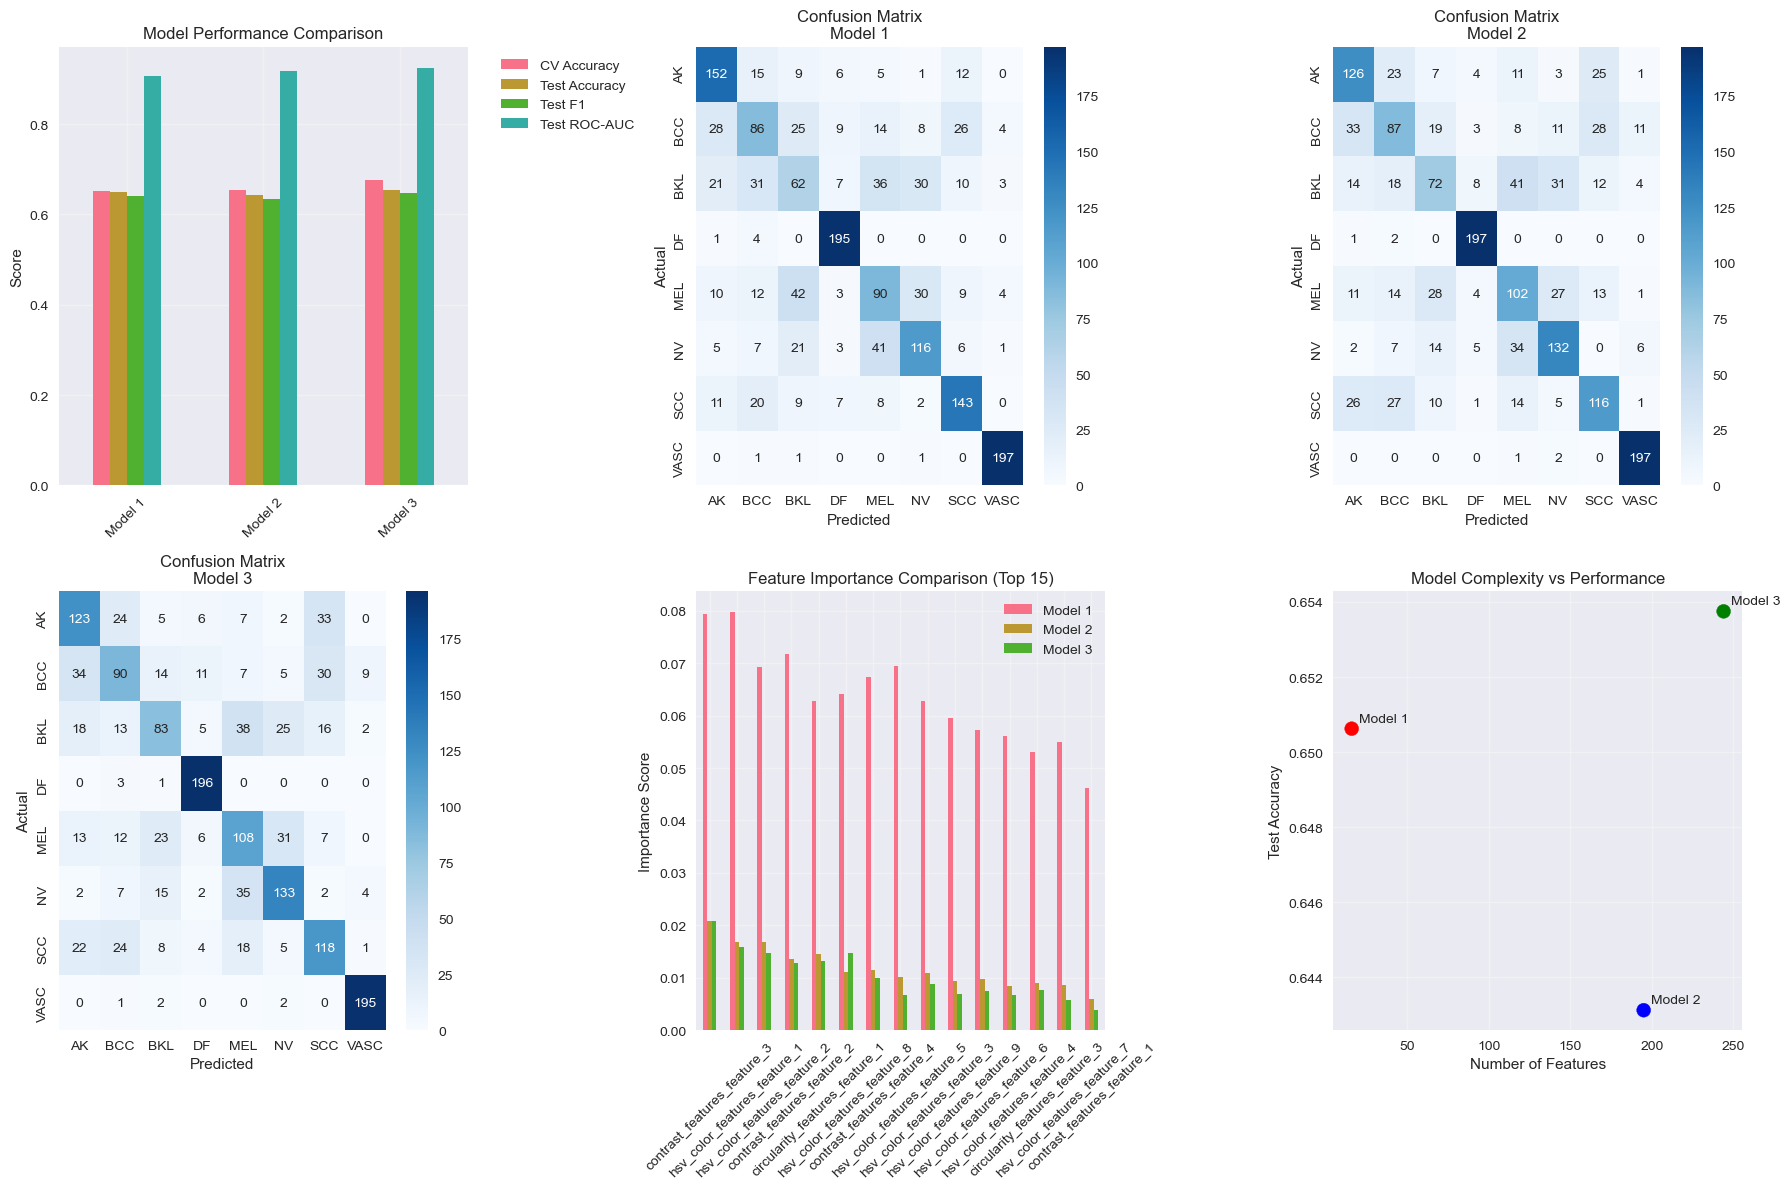


DETAILED MODEL COMPARISON
  Model  Features     CV Accuracy Test Accuracy Test F1 Test ROC-AUC
Model 1        16 0.6514 ± 0.0076        0.6506  0.6417       0.9067
Model 2       195 0.6539 ± 0.0100        0.6431  0.6349       0.9183
Model 3       244 0.6773 ± 0.0156        0.6538  0.6470       0.9250

Best performing model: Model 3 (All features)
Test accuracy: 0.6538


In [24]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

def create_xgboost_models(df, test_size=0.2, random_state=42):
    """
    Create and evaluate three XGBoost models with different feature sets.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Combined features dataframe
    test_size : float
        Proportion of data for testing
    random_state : int
        Random state for reproducibility
    
    Returns:
    --------
    dict : Results for all three models
    """
    
    print("Creating XGBoost models with different feature sets...")
    print(f"Dataset shape: {df.shape}")
    print(f"Label distribution:\n{df['Label'].value_counts()}")
    
    # Prepare labels
    le = LabelEncoder()
    y = le.fit_transform(df['Label'])
    label_names = le.classes_
    
    print(f"\nEncoded labels: {dict(zip(label_names, range(len(label_names))))}")
    
    # Define feature sets
    non_pca_features = [col for col in df.columns if any(prefix in col for prefix in 
                       ['circularity_features', 'hsv_color_features', 'contrast_features'])]
    
    pca_features_no_efficient = [col for col in df.columns if 'PC' in col and 'efficientnet' not in col]
    
    all_pca_features = [col for col in df.columns if 'PC' in col]
    
    feature_sets = {
        'Model 1 (Non-PCA only)': non_pca_features,
        'Model 2 (Non-PCA + PCA w/o EfficientNet)': non_pca_features + pca_features_no_efficient,
        'Model 3 (All features)': non_pca_features + pca_features_no_efficient + [col for col in all_pca_features if 'efficientnet' in col]
    }
    
    print(f"\nFeature set sizes:")
    for name, features in feature_sets.items():
        print(f"  {name}: {len(features)} features")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        df[['ID'] + list(set().union(*feature_sets.values()))], y, 
        test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"\nTrain/Test split:")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Testing samples: {len(X_test)}")
    print(f"  Training label distribution: {np.bincount(y_train)}")
    print(f"  Testing label distribution: {np.bincount(y_test)}")
    
    results = {}
    
    # Train and evaluate each model
    for model_name, features in feature_sets.items():
        print(f"\n{'='*60}")
        print(f"Training {model_name}")
        print(f"{'='*60}")
        
        # Prepare data for this model
        X_train_model = X_train[features]
        X_test_model = X_test[features]
        
        print(f"Feature matrix shape: {X_train_model.shape}")
        
        # Create XGBoost model for training with early stopping
        xgb_model_with_early_stopping = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=random_state,
            eval_metric='mlogloss' if len(label_names) > 2 else 'logloss',
            early_stopping_rounds=20,
            verbose=False
        )
        
        # Create XGBoost model for cross-validation (without early stopping)
        xgb_model_cv = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=random_state,
            eval_metric='mlogloss' if len(label_names) > 2 else 'logloss',
            verbose=False
        )
        
        # Train model with validation set for early stopping
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train_model, y_train, test_size=0.2, random_state=random_state, stratify=y_train
        )
        
        xgb_model_with_early_stopping.fit(
            X_train_split, y_train_split,
            eval_set=[(X_val_split, y_val_split)],
            verbose=False
        )
        
        # Cross-validation with model without early stopping
        print("Performing cross-validation...")
        cv_scores = cross_val_score(
            xgb_model_cv, X_train_model, y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
            scoring='accuracy'
        )
        
        # Use the model with early stopping for final predictions
        xgb_model = xgb_model_with_early_stopping
        
        # Predictions
        y_pred = xgb_model.predict(X_test_model)
        y_pred_proba = xgb_model.predict_proba(X_test_model)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # ROC AUC (handle multiclass)
        if len(label_names) == 2:
            roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        else:
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        
        # Classification report
        class_report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': xgb_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Store results
        results[model_name] = {
            'model': xgb_model,
            'features': features,
            'cv_scores': cv_scores,
            'test_accuracy': accuracy,
            'test_f1': f1,
            'test_roc_auc': roc_auc,
            'classification_report': class_report,
            'confusion_matrix': conf_matrix,
            'feature_importance': feature_importance,
            'predictions': y_pred,
            'prediction_probabilities': y_pred_proba
        }
        
        # Print results
        print(f"\nResults for {model_name}:")
        print(f"  Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"  Test accuracy: {accuracy:.4f}")
        print(f"  Test F1-score (weighted): {f1:.4f}")
        print(f"  Test ROC-AUC: {roc_auc:.4f}")
        
        print(f"\nTop 10 most important features:")
        for i, row in feature_importance.head(10).iterrows():
            print(f"    {row['feature']}: {row['importance']:.4f}")
    
    # Create comparison plots
    _plot_model_comparison(results, label_names)
    
    return results, X_test, y_test, label_names

def _plot_model_comparison(results, label_names):
    """
    Create comprehensive comparison plots for the three models.
    """
    
    # Set up the plotting layout
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Model performance comparison
    model_names = list(results.keys())
    metrics = ['cv_scores', 'test_accuracy', 'test_f1', 'test_roc_auc']
    
    # Bar plot of performance metrics
    performance_data = []
    for model_name in model_names:
        performance_data.append([
            results[model_name]['cv_scores'].mean(),
            results[model_name]['test_accuracy'],
            results[model_name]['test_f1'],
            results[model_name]['test_roc_auc']
        ])
    
    performance_df = pd.DataFrame(
        performance_data,
        index=[name.split('(')[0].strip() for name in model_names],
        columns=['CV Accuracy', 'Test Accuracy', 'Test F1', 'Test ROC-AUC']
    )
    
    performance_df.plot(kind='bar', ax=axes[0, 0], rot=45)
    axes[0, 0].set_title('Model Performance Comparison')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Confusion matrices for each model
    for i, (model_name, result) in enumerate(results.items()):
        row = (i + 1) // 3
        col = (i + 1) % 3
        
        if i < 2:  # Plot confusion matrices for first two models in top row
            ax = axes[0, i + 1]
        else:  # Plot third confusion matrix in bottom row
            ax = axes[1, 0]
        
        conf_matrix = result['confusion_matrix']
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_names, yticklabels=label_names, ax=ax)
        ax.set_title(f'Confusion Matrix\n{model_name.split("(")[0].strip()}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    # Feature importance comparison for top features
    # Get top 15 features from all models combined
    all_features = set()
    for result in results.values():
        all_features.update(result['feature_importance'].head(15)['feature'].tolist())
    
    importance_comparison = pd.DataFrame(index=list(all_features))
    for model_name, result in results.items():
        feat_imp = result['feature_importance'].set_index('feature')['importance']
        model_short = model_name.split('(')[0].strip()
        importance_comparison[model_short] = feat_imp
    
    importance_comparison = importance_comparison.fillna(0)
    top_features = importance_comparison.sum(axis=1).nlargest(15).index
    
    importance_comparison.loc[top_features].plot(kind='bar', ax=axes[1, 1], rot=45)
    axes[1, 1].set_title('Feature Importance Comparison (Top 15)')
    axes[1, 1].set_ylabel('Importance Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Model complexity vs performance
    model_complexities = [len(result['features']) for result in results.values()]
    test_accuracies = [result['test_accuracy'] for result in results.values()]
    
    axes[1, 2].scatter(model_complexities, test_accuracies, s=100, c=['red', 'blue', 'green'])
    for i, model_name in enumerate(model_names):
        axes[1, 2].annotate(f'Model {i+1}', 
                           (model_complexities[i], test_accuracies[i]),
                           xytext=(5, 5), textcoords='offset points')
    
    axes[1, 2].set_xlabel('Number of Features')
    axes[1, 2].set_ylabel('Test Accuracy')
    axes[1, 2].set_title('Model Complexity vs Performance')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print(f"\n{'='*80}")
    print("DETAILED MODEL COMPARISON")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame({
        'Model': [name.split('(')[0].strip() for name in model_names],
        'Features': [len(result['features']) for result in results.values()],
        'CV Accuracy': [f"{result['cv_scores'].mean():.4f} ± {result['cv_scores'].std():.4f}" 
                       for result in results.values()],
        'Test Accuracy': [f"{result['test_accuracy']:.4f}" for result in results.values()],
        'Test F1': [f"{result['test_f1']:.4f}" for result in results.values()],
        'Test ROC-AUC': [f"{result['test_roc_auc']:.4f}" for result in results.values()]
    })
    
    print(comparison_df.to_string(index=False))
    
    # Best model summary
    best_model = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
    print(f"\nBest performing model: {best_model}")
    print(f"Test accuracy: {results[best_model]['test_accuracy']:.4f}")

# Run the XGBoost model comparison
model_results, X_test_data, y_test_data, label_names = create_xgboost_models(df)

Creating SVM models with different feature sets...
Dataset shape: (8000, 246)
Label distribution:
Label
NV      1000
MEL     1000
BCC     1000
BKL     1000
AK      1000
SCC     1000
VASC    1000
DF      1000
Name: count, dtype: int64

Encoded labels: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

Feature set sizes:
  Model 1 (Non-PCA only): 16 features
  Model 2 (Non-PCA + PCA w/o EfficientNet): 195 features
  Model 3 (All features): 244 features

Train/Test split:
  Training samples: 6400
  Testing samples: 1600
  Training label distribution: [800 800 800 800 800 800 800 800]
  Testing label distribution: [200 200 200 200 200 200 200 200]

Training Model 1 (Non-PCA only)
Feature matrix shape: (6400, 16)
Performing cross-validation...

Results for Model 1 (Non-PCA only):
  Cross-validation accuracy: 0.4686 (+/- 0.0229)
  Test accuracy: 0.4806
  Test F1-score (weighted): 0.4717
  Test ROC-AUC: 0.8371

Training Model 2 (Non-PCA + PCA w/o EfficientNet)
Fea

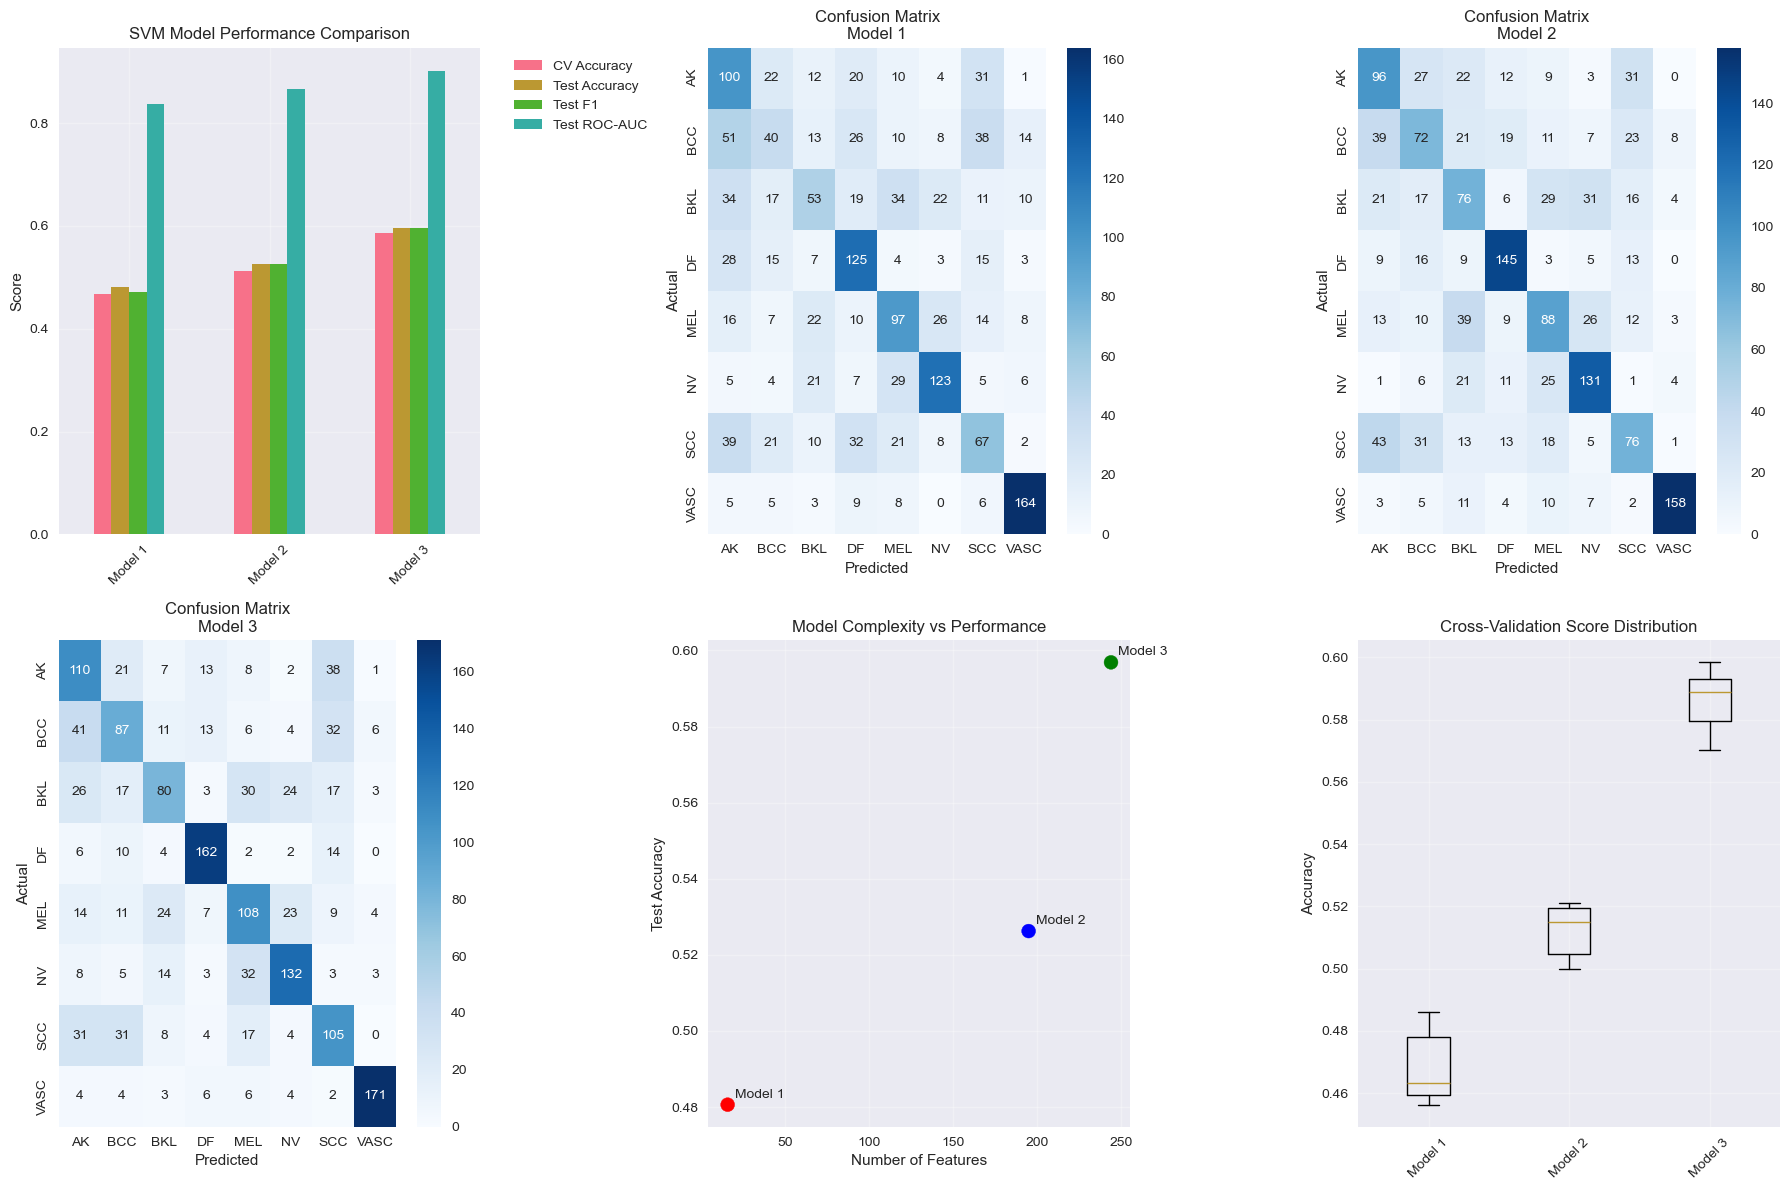


DETAILED SVM MODEL COMPARISON
  Model  Features     CV Accuracy Test Accuracy Test F1 Test ROC-AUC
Model 1        16 0.4686 ± 0.0115        0.4806  0.4717       0.8371
Model 2       195 0.5120 ± 0.0083        0.5262  0.5262       0.8659
Model 3       244 0.5861 ± 0.0100        0.5969  0.5966       0.9018

Best performing SVM model: Model 3 (All features)
Test accuracy: 0.5969


In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

def create_svm_models(df, test_size=0.2, random_state=42):
    """
    Create and evaluate three SVM models with different feature sets.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Combined features dataframe
    test_size : float
        Proportion of data for testing
    random_state : int
        Random state for reproducibility
    
    Returns:
    --------
    dict : Results for all three models
    """
    
    print("Creating SVM models with different feature sets...")
    print(f"Dataset shape: {df.shape}")
    print(f"Label distribution:\n{df['Label'].value_counts()}")
    
    # Prepare labels
    le = LabelEncoder()
    y = le.fit_transform(df['Label'])
    label_names = le.classes_
    
    print(f"\nEncoded labels: {dict(zip(label_names, range(len(label_names))))}")
    
    # Define feature sets
    non_pca_features = [col for col in df.columns if any(prefix in col for prefix in 
                       ['circularity_features', 'hsv_color_features', 'contrast_features'])]
    
    pca_features_no_efficient = [col for col in df.columns if 'PC' in col and 'efficientnet' not in col]
    
    all_pca_features = [col for col in df.columns if 'PC' in col]
    
    feature_sets = {
        'Model 1 (Non-PCA only)': non_pca_features,
        'Model 2 (Non-PCA + PCA w/o EfficientNet)': non_pca_features + pca_features_no_efficient,
        'Model 3 (All features)': non_pca_features + pca_features_no_efficient + [col for col in all_pca_features if 'efficientnet' in col]
    }
    
    print(f"\nFeature set sizes:")
    for name, features in feature_sets.items():
        print(f"  {name}: {len(features)} features")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        df[['ID'] + list(set().union(*feature_sets.values()))], y, 
        test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"\nTrain/Test split:")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Testing samples: {len(X_test)}")
    print(f"  Training label distribution: {np.bincount(y_train)}")
    print(f"  Testing label distribution: {np.bincount(y_test)}")
    
    results = {}
    
    # Train and evaluate each model
    for model_name, features in feature_sets.items():
        print(f"\n{'='*60}")
        print(f"Training {model_name}")
        print(f"{'='*60}")
        
        # Prepare data for this model
        X_train_model = X_train[features]
        X_test_model = X_test[features]
        
        print(f"Feature matrix shape: {X_train_model.shape}")
        
        # Scale features for SVM (important for SVM)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_model)
        X_test_scaled = scaler.transform(X_test_model)
        
        # Create SVM model
        svm_model = SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            probability=True,  # Enable probability estimates for ROC-AUC
            random_state=random_state
        )
        
        # Cross-validation
        print("Performing cross-validation...")
        cv_scores = cross_val_score(
            svm_model, X_train_scaled, y_train,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
            scoring='accuracy'
        )
        
        # Train model
        svm_model.fit(X_train_scaled, y_train)
        
        # Predictions
        y_pred = svm_model.predict(X_test_scaled)
        y_pred_proba = svm_model.predict_proba(X_test_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # ROC AUC (handle multiclass)
        if len(label_names) == 2:
            roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
        else:
            roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
        
        # Classification report
        class_report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)
        
        # Confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Store results (SVM doesn't have feature importance)
        results[model_name] = {
            'model': svm_model,
            'scaler': scaler,
            'features': features,
            'cv_scores': cv_scores,
            'test_accuracy': accuracy,
            'test_f1': f1,
            'test_roc_auc': roc_auc,
            'classification_report': class_report,
            'confusion_matrix': conf_matrix,
            'predictions': y_pred,
            'prediction_probabilities': y_pred_proba
        }
        
        # Print results
        print(f"\nResults for {model_name}:")
        print(f"  Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        print(f"  Test accuracy: {accuracy:.4f}")
        print(f"  Test F1-score (weighted): {f1:.4f}")
        print(f"  Test ROC-AUC: {roc_auc:.4f}")
    
    # Create comparison plots
    _plot_svm_comparison(results, label_names)
    
    return results, X_test, y_test, label_names

def _plot_svm_comparison(results, label_names):
    """
    Create comprehensive comparison plots for the three SVM models.
    """
    
    # Set up the plotting layout
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Model performance comparison
    model_names = list(results.keys())
    
    # Bar plot of performance metrics
    performance_data = []
    for model_name in model_names:
        performance_data.append([
            results[model_name]['cv_scores'].mean(),
            results[model_name]['test_accuracy'],
            results[model_name]['test_f1'],
            results[model_name]['test_roc_auc']
        ])
    
    performance_df = pd.DataFrame(
        performance_data,
        index=[name.split('(')[0].strip() for name in model_names],
        columns=['CV Accuracy', 'Test Accuracy', 'Test F1', 'Test ROC-AUC']
    )
    
    performance_df.plot(kind='bar', ax=axes[0, 0], rot=45)
    axes[0, 0].set_title('SVM Model Performance Comparison')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Confusion matrices for each model
    for i, (model_name, result) in enumerate(results.items()):
        if i < 2:  # Plot confusion matrices for first two models in top row
            ax = axes[0, i + 1]
        else:  # Plot third confusion matrix in bottom row
            ax = axes[1, 0]
        
        conf_matrix = result['confusion_matrix']
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_names, yticklabels=label_names, ax=ax)
        ax.set_title(f'Confusion Matrix\n{model_name.split("(")[0].strip()}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
    
    # Model complexity vs performance
    model_complexities = [len(result['features']) for result in results.values()]
    test_accuracies = [result['test_accuracy'] for result in results.values()]
    
    axes[1, 1].scatter(model_complexities, test_accuracies, s=100, c=['red', 'blue', 'green'])
    for i, model_name in enumerate(model_names):
        axes[1, 1].annotate(f'Model {i+1}', 
                           (model_complexities[i], test_accuracies[i]),
                           xytext=(5, 5), textcoords='offset points')
    
    axes[1, 1].set_xlabel('Number of Features')
    axes[1, 1].set_ylabel('Test Accuracy')
    axes[1, 1].set_title('Model Complexity vs Performance')
    axes[1, 1].grid(True, alpha=0.3)
    
    # CV scores distribution
    cv_data = []
    labels = []
    for model_name, result in results.items():
        cv_data.append(result['cv_scores'])
        labels.append(model_name.split('(')[0].strip())
    
    axes[1, 2].boxplot(cv_data, labels=labels)
    axes[1, 2].set_title('Cross-Validation Score Distribution')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print(f"\n{'='*80}")
    print("DETAILED SVM MODEL COMPARISON")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame({
        'Model': [name.split('(')[0].strip() for name in model_names],
        'Features': [len(result['features']) for result in results.values()],
        'CV Accuracy': [f"{result['cv_scores'].mean():.4f} ± {result['cv_scores'].std():.4f}" 
                       for result in results.values()],
        'Test Accuracy': [f"{result['test_accuracy']:.4f}" for result in results.values()],
        'Test F1': [f"{result['test_f1']:.4f}" for result in results.values()],
        'Test ROC-AUC': [f"{result['test_roc_auc']:.4f}" for result in results.values()]
    })
    
    print(comparison_df.to_string(index=False))
    
    # Best model summary
    best_model = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
    print(f"\nBest performing SVM model: {best_model}")
    print(f"Test accuracy: {results[best_model]['test_accuracy']:.4f}")

# Run the SVM model comparison
svm_results, X_test_svm, y_test_svm, label_names_svm = create_svm_models(df)